In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import tableone
from tqdm import tqdm
import os
import random
from PIL import Image

In [4]:
def dataframe_stats(df, title: str or None = None):
    if title is not None:
        print(f"\n{title}")
        
    num_patients = df.empi_anon.nunique()
    num_exams = df.acc_anon.nunique()
    
    print(f"Patients: {num_patients}")
    print(f"Exams: {num_exams}")
    
    if 'png_path' in df.columns:
        print(f"Images: {len(df)}")
        
def plot_feature_density(feature, depth: int = 1, cmap: str = 'viridis'):
    # get colormap object
    cm = plt.get_cmap(cmap)
    
    # create the density plot
    axis = feature.plot.density(
        xlim=(feature.min(), feature.max()), 
        color=cm(0.0)
    )

    # get mean and standard deviation for age
    var_mean = feature.mean()
    var_std = feature.std()

    line = axis.get_lines()[0]

    # extract x and y data from the line object
    x = line.get_xdata()
    y = line.get_ydata()
    
    # plot mean
    axis.axvline(var_mean, color=cm(1.0), linestyle='--', label='Mean')
    
    # iterate over std depth levels
    for i in range(depth, 0, -1):
        # get bounds of std interval
        sigma_min, sigma_max = var_mean-(i*var_std), var_mean+(i*var_std)
        
        # mask array between bounds
        array_mask = (x >= sigma_min) & (x <= sigma_max)
        
        # plot std interval
        sigma_value = 0.7 / i
        axis.fill_between(x, y, where=array_mask, color=cm(sigma_value), alpha=0.3, label=f'{i}σ')
        
    ax.legend()
        
    return axis

In [5]:
base_directory = "/embed"
mag_path = base_directory + "/tables/embed_datathon_magview_reduced.csv"
meta_path = base_directory + "/tables/embed_datathon_metadata_reduced.csv"

# load clinical data from magview
mag_df = pd.read_csv(mag_path)
dataframe_stats(mag_df, 'magview:')

# load image metadata
meta_df = pd.read_csv(meta_path)
dataframe_stats(meta_df, 'metadata:')

/tmp/ipykernel_27336/2115225167.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  mag_df = pd.read_csv(mag_path)



magview:
Patients: 115883
Exams: 364733


/tmp/ipykernel_27336/2115225167.py:10: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(meta_path)



metadata:
Patients: 115894
Exams: 364733
Images: 2403687


In [8]:
mag_df.columns

Index(['empi_anon', 'acc_anon', 'desc', 'numfind', 'side', 'asses',
       'tissueden', 'bside', 'type', 'GENDER_DESC', 'ETHNICITY_DESC',
       'ETHNIC_GROUP_DESC', 'MARITAL_STATUS_DESC', 'age_at_study',
       'study_date_anon', 'procdate_anon', 'cohort_num', 'path_severity',
       'total_L_find', 'total_R_find', 'first_3_zip', 'massshape',
       'massmargin', 'massdens', 'calcfind', 'calcdistri', 'calcnumber'],
      dtype='object')

In [11]:
mag_df['exam_type'] = 'Other'
mag_df.loc[mag_df['desc'].str.contains('screen', case=False), 'exam_type'] = 'Screening'
mag_df.loc[mag_df['desc'].str.contains('diag', case=False), 'exam_type'] = 'Diagnostic'
tableone(mag_df, ['asses'], groupby=['exam_type'])

Grouped by exam_type                                            
                            Missing        Overall    Diagnostic      Screening
n                                           408464        112277         296187
asses, n (%) A                    0   57479 (14.1)    2780 (2.5)   54699 (18.5)
             B                        75969 (18.6)  43031 (38.3)   32938 (11.1)
             K                          2031 (0.5)    2018 (1.8)       13 (0.0)
             M                          1639 (0.4)    1634 (1.5)        5 (0.0)
             N                       228979 (56.1)  20619 (18.4)  208360 (70.3)
             P                         27444 (6.7)  27365 (24.4)       79 (0.0)
             S                         14817 (3.6)  14728 (13.1)       89 (0.0)
             X                           106 (0.0)     102 (0.1)        4 (0.0)

In [22]:
# ensure our study date column is read as a datetime
mag_df['study_date_anon'] = pd.to_datetime(mag_df['study_date_anon'], errors='coerce', format= '%Y-%m-%d')

# get diagnostic exams with BIRADS 1/2/4/5
mag_diag_pos_df = mag_df[mag_df.asses.isin(['N', 'B', 'S','M']) & mag_df.desc.str.contains('diag', case=False)]

# get relevant columns to prepare for merge with screening exams
diag_cols = ['empi_anon', 'acc_anon', 'numfind', 'side', 'study_date_anon', 'asses']
mag_diag_pos_reduced_df = mag_diag_pos_df[diag_cols]

dataframe_stats(mag_diag_pos_reduced_df, 'mag_diag_pos_reduced_df:')

# rename columns to prepare for the merge
mag_diag_pos_reduced_df.columns = [
    'empi_anon', 
    'acc_anon_diag', 
    'diag_num', 
    'diag_side', 
    'diag_study_date', 
    'diag_asses'
]


mag_diag_pos_reduced_df:
Patients: 44050
Exams: 62221


In [24]:
# get dataframe of screening exams
mag_scr_df = mag_df[mag_df.desc.str.contains('screen', case=False)]

# left merge on empi_anon
mag_scr_pos_df = mag_diag_pos_reduced_df.merge(mag_scr_df, on='empi_anon', how='left')

dataframe_stats(mag_scr_pos_df, 'mag_scr_pos_df:')


mag_scr_pos_df:
Patients: 44050
Exams: 103890


In [29]:
# keep screening exams with the same laterality as the subsequent diagnostic exams
mag_scr_pos_df = mag_scr_pos_df.loc[(mag_scr_pos_df.side == mag_scr_pos_df.diag_side)]

dataframe_stats(mag_scr_pos_df, 'mag_scr_pos_df: (after side filtering)')

# get time difference between diagnostic and screening exams
mag_scr_pos_df['study_date_diff'] = mag_scr_pos_df.diag_study_date - mag_scr_pos_df.study_date_anon

# keep only screening exams with a time diff
mag_scr_pos_rel_df = mag_scr_pos_df.loc[(mag_scr_pos_df.study_date_diff.dt.days >= 0) & 
                                        (mag_scr_pos_df.study_date_diff.dt.days <= 360)]

dataframe_stats(mag_scr_pos_rel_df, 'mag_scr_pos_rel_df: (after date filtering)')


mag_scr_pos_df: (after side filtering)
Patients: 25149
Exams: 38750

mag_scr_pos_rel_df: (after date filtering)
Patients: 20754
Exams: 23064


In [30]:
# define a list of columns from meta_df to retain
meta_cols = ['acc_anon', 'ImageLateralityFinal', 'png_path']

# filter the dataframe to only contain 2D images
meta_2d_df = meta_df[meta_df.FinalImageType == '2D']

# merge positive magview dataframe with metadata
meta_2d_scr_pos_df = mag_scr_pos_rel_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_pos_rel_df, 'mag_scr_pos_rel_df')
dataframe_stats(meta_2d_scr_pos_df, 'meta_2d_scr_pos_df: (merged)')


mag_scr_pos_rel_df
Patients: 20754
Exams: 23064

meta_2d_scr_pos_df: (merged)
Patients: 20530
Exams: 22811
Images: 100987


In [31]:
meta_2d_scr_pos_df

,empi_anon,acc_anon_diag,diag_num,diag_side,diag_study_date,diag_asses,acc_anon,desc,numfind,side,...,massshape,massmargin,massdens,calcfind,calcdistri,calcnumber,exam_type,study_date_diff,ImageLateralityFinal,png_path
0,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...
1,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...
2,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...
3,16775402,9658035771684590,1,L,2013-03-17,N,3.639098e+15,MG Screening Bilateral w/CAD,1.0,L,...,S,NaN,NaN,NaN,NaN,0.0,Screening,35 days,L,/embed/images/cohort_1/extracted-images/3aef92...
4,16775402,9658035771684590,1,L,2013-03-17,N,3.639098e+15,MG Screening Bilateral w/CAD,1.0,L,...,S,NaN,NaN,NaN,NaN,0.0,Screening,35 days,L,/embed/images/cohort_1/extracted-images/3aef92...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100982,49495394,6115719959592980,1,L,2020-10-31,B,2.927178e+15,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1.0,L,...,NaN,NaN,NaN,NaN,NaN,0.0,Screening,15 days,L,/embed/images/cohort_10/extracted-images/93120...
100983,50020271,6690811192177295,1,L,2021-01-30,B,1.974781e+15,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1.0,L,...,O,NaN,NaN,NaN,NaN,0.0,Screening,291 days,L,/embed/images/cohort_10/extracted-images/d1589...
100984,50020271,6690811192177295,1,L,2021-01-30,B,1.974781e+15,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1.0,L,...,O,NaN,NaN,NaN,NaN,0.0,Screening,291 days,L,/embed/images/cohort_10/extracted-images/d1589...
100985,65406994,2854221732204499,1,L,2020-04-08,B,8.661066e+15,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1.0,L,...,S,NaN,NaN,NaN,NaN,0.0,Screening,39 days,L,/embed/images/cohort_10/extracted-images/43452...


In [32]:
meta_2d_scr_pos_df[meta_2d_scr_pos_df['empi_anon'] == 70270720]

,empi_anon,acc_anon_diag,diag_num,diag_side,diag_study_date,diag_asses,acc_anon,desc,numfind,side,...,massshape,massmargin,massdens,calcfind,calcdistri,calcnumber,exam_type,study_date_diff,ImageLateralityFinal,png_path
0,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...
1,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...
2,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...


In [33]:
meta_2d_scr_pos_df.study_date_diff.value_counts()

study_date_diff
14 days     4411
21 days     3229
28 days     2904
20 days     2753
7 days      2430
            ... 
173 days       8
150 days       6
158 days       6
166 days       6
151 days       6
Name: count, Length: 361, dtype: int64

In [42]:
meta_2d_scr_pos_df.study_date_diff.max()

Timedelta('360 days 00:00:00')

In [43]:
meta_2d_scr_pos_df.study_date_diff.min()

Timedelta('0 days 00:00:00')

In [44]:
meta_2d_scr_pos_df.study_date_diff.mean()

Timedelta('60 days 15:16:59.929297830')

In [46]:
meta_2d_scr_pos_df.columns

Index(['empi_anon', 'acc_anon_diag', 'diag_num', 'diag_side',
       'diag_study_date', 'diag_asses', 'acc_anon', 'desc', 'numfind', 'side',
       'asses', 'tissueden', 'bside', 'type', 'GENDER_DESC', 'ETHNICITY_DESC',
       'ETHNIC_GROUP_DESC', 'MARITAL_STATUS_DESC', 'age_at_study',
       'study_date_anon', 'procdate_anon', 'cohort_num', 'path_severity',
       'total_L_find', 'total_R_find', 'first_3_zip', 'massshape',
       'massmargin', 'massdens', 'calcfind', 'calcdistri', 'calcnumber',
       'exam_type', 'study_date_diff', 'ImageLateralityFinal', 'png_path',
       'date_num'],
      dtype='object')

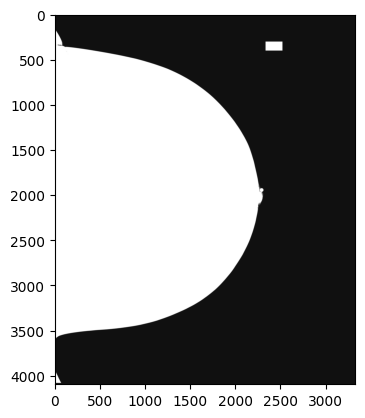

In [51]:
plt.imshow(Image.open(meta_2d_scr_pos_df.png_path.iloc[0]))
plt.show()

In [53]:
img_array = np.array(Image.open(meta_2d_scr_pos_df.png_path.iloc[0]))
print(img_array.min(), img_array.max())

16 65535


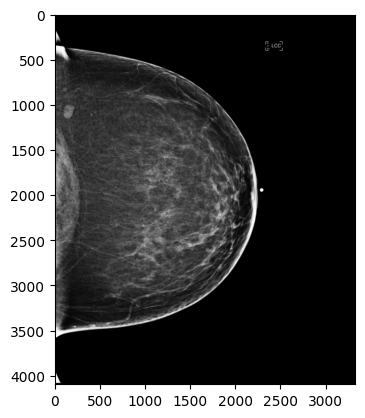

In [55]:
img_array = img_array + np.abs(img_array.min())
img_array = img_array / img_array.max()
plt.imshow(img_array, cmap='gray')
plt.show()

In [56]:
meta_2d_scr_pos_df

,empi_anon,acc_anon_diag,diag_num,diag_side,diag_study_date,diag_asses,acc_anon,desc,numfind,side,...,massmargin,massdens,calcfind,calcdistri,calcnumber,exam_type,study_date_diff,ImageLateralityFinal,png_path,date_num
0,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...,2678400000000000
1,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...,2678400000000000
2,70270720,2327819077874596,1,L,2012-10-05,S,7.625247e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,G,NaN,0.0,Screening,31 days,L,/embed/images/cohort_1/extracted-images/eb887c...,2678400000000000
3,16775402,9658035771684590,1,L,2013-03-17,N,3.639098e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,NaN,NaN,0.0,Screening,35 days,L,/embed/images/cohort_1/extracted-images/3aef92...,3024000000000000
4,16775402,9658035771684590,1,L,2013-03-17,N,3.639098e+15,MG Screening Bilateral w/CAD,1.0,L,...,NaN,NaN,NaN,NaN,0.0,Screening,35 days,L,/embed/images/cohort_1/extracted-images/3aef92...,3024000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100982,49495394,6115719959592980,1,L,2020-10-31,B,2.927178e+15,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1.0,L,...,NaN,NaN,NaN,NaN,0.0,Screening,15 days,L,/embed/images/cohort_10/extracted-images/93120...,1296000000000000
100983,50020271,6690811192177295,1,L,2021-01-30,B,1.974781e+15,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1.0,L,...,NaN,NaN,NaN,NaN,0.0,Screening,291 days,L,/embed/images/cohort_10/extracted-images/d1589...,25142400000000000
100984,50020271,6690811192177295,1,L,2021-01-30,B,1.974781e+15,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1.0,L,...,NaN,NaN,NaN,NaN,0.0,Screening,291 days,L,/embed/images/cohort_10/extracted-images/d1589...,25142400000000000
100985,65406994,2854221732204499,1,L,2020-04-08,B,8.661066e+15,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1.0,L,...,NaN,NaN,NaN,NaN,0.0,Screening,39 days,L,/embed/images/cohort_10/extracted-images/43452...,3369600000000000


In [57]:
meta_2d_scr_pos_df.columns

Index(['empi_anon', 'acc_anon_diag', 'diag_num', 'diag_side',
       'diag_study_date', 'diag_asses', 'acc_anon', 'desc', 'numfind', 'side',
       'asses', 'tissueden', 'bside', 'type', 'GENDER_DESC', 'ETHNICITY_DESC',
       'ETHNIC_GROUP_DESC', 'MARITAL_STATUS_DESC', 'age_at_study',
       'study_date_anon', 'procdate_anon', 'cohort_num', 'path_severity',
       'total_L_find', 'total_R_find', 'first_3_zip', 'massshape',
       'massmargin', 'massdens', 'calcfind', 'calcdistri', 'calcnumber',
       'exam_type', 'study_date_diff', 'ImageLateralityFinal', 'png_path',
       'date_num'],
      dtype='object')

In [58]:
meta_2d_scr_pos_df.path_severity.value_counts()

path_severity
4.0    15669
0.0     8545
2.0     7478
1.0     4138
5.0      264
3.0      155
Name: count, dtype: int64

In [60]:
meta_2d_scr_pos_df_breastC = meta_2d_scr_pos_df[meta_2d_scr_pos_df['path_severity'] != 5]
meta_2d_scr_pos_df_breastC.path_severity.value_counts()

path_severity
4.0    15669
0.0     8545
2.0     7478
1.0     4138
3.0      155
Name: count, dtype: int64

In [64]:
len(meta_2d_scr_pos_df_breastC)

100723

In [68]:
cancer_label = []
for i in range(len(meta_2d_scr_pos_df_breastC)):
    path_sev = meta_2d_scr_pos_df_breastC['path_severity'].iloc[i]
    if path_sev == 0 or path_sev == 1:
        cancer_label.append(1)
    elif path_sev in [2,3,4]:
        cancer_label.append(0)
    else:
        cancer_label.append(-1)
meta_2d_scr_pos_df_breastC['cancer'] = cancer_label
meta_2d_scr_pos_df_breastC['cancer'].value_counts()

/tmp/ipykernel_27336/523029630.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_2d_scr_pos_df_breastC['cancer'] = cancer_label


cancer
-1    64738
 0    23302
 1    12683
Name: count, dtype: int64

In [71]:
meta_2d_scr_pos_df_breastC.columns

Index(['empi_anon', 'acc_anon_diag', 'diag_num', 'diag_side',
       'diag_study_date', 'diag_asses', 'acc_anon', 'desc', 'numfind', 'side',
       'asses', 'tissueden', 'bside', 'type', 'GENDER_DESC', 'ETHNICITY_DESC',
       'ETHNIC_GROUP_DESC', 'MARITAL_STATUS_DESC', 'age_at_study',
       'study_date_anon', 'procdate_anon', 'cohort_num', 'path_severity',
       'total_L_find', 'total_R_find', 'first_3_zip', 'massshape',
       'massmargin', 'massdens', 'calcfind', 'calcdistri', 'calcnumber',
       'exam_type', 'study_date_diff', 'ImageLateralityFinal', 'png_path',
       'date_num', 'cancer'],
      dtype='object')

In [72]:
meta_2d_scr_pos_df_breastC.ETHNICITY_DESC.value_counts()

ETHNICITY_DESC
African American or Black                    48375
Caucasian or White                           41041
Unknown, Unavailable or Unreported            5434
Asian                                         4050
Native Hawaiian or Other Pacific Islander     1116
Multiple                                       319
American Indian or Alaskan Native              137
Hispanic                                        16
Name: count, dtype: int64

In [77]:
meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'African American or Black') & (meta_2d_scr_pos_df_breastC['cancer'] != -1)]['cancer'].value_counts(normalize=True)

cancer
0    0.696331
1    0.303669
Name: proportion, dtype: float64

In [78]:
meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'Caucasian or White') & (meta_2d_scr_pos_df_breastC['cancer'] != -1)]['cancer'].value_counts(normalize=True)

cancer
0    0.556084
1    0.443916
Name: proportion, dtype: float64

In [79]:
meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'African American or Black')]['cancer'].value_counts(normalize=True)

cancer
-1    0.605581
 0    0.274646
 1    0.119773
Name: proportion, dtype: float64

In [80]:
meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'Caucasian or White')]['cancer'].value_counts(normalize=True)

cancer
-1    0.656782
 0    0.190858
 1    0.152360
Name: proportion, dtype: float64